This notebook:
- ML on data from event_generation.ipynb (DWT performed on events)
- hyperparameter tuning
- feature importances
- misclassification analysis (a bit)

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import signal
from scipy.signal import find_peaks, peak_widths
import pyabf
import pyabf.filter
from multiprocessing import Pool
import pywt

from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats import kurtosis
import seaborn as sns
from scipy.stats import randint

from matplotlib.ticker import MaxNLocator
import sklearn
from sklearn.cluster import DBSCAN
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from scipy.stats import entropy
from collections import Counter

In [24]:
import importlib
import all_funcs
importlib.reload(all_funcs)
from all_funcs import *

### Loading data

In [2]:
import pickle

def unpickle(pickle_file):
    with open(pickle_file, 'rb') as f:
        return pickle.load(f)
    

In [3]:
all_event_time_5nm = unpickle('all_event_time_5nm.pkl')
all_event_time_10nm = unpickle('all_event_time_10nm.pkl')
all_event_data_5nm = unpickle('all_event_data_5nm.pkl')
all_event_data_10nm = unpickle('all_event_data_10nm.pkl')

In [4]:
all_event_time = []
for i in all_event_time_5nm + all_event_time_10nm:
    all_event_time += i
    
all_event_data = []
for i in all_event_data_5nm + all_event_data_10nm:
    all_event_data += i

In [5]:
X = unpickle('data_X_features.pkl')
y = unpickle('data_y_labels.pkl')

In [6]:
X_all_nocoeff = unpickle('all_X_features_nocoeffs.pkl')
y_all = unpickle('all_y_labels.pkl')

In [7]:
X_no1920 = unpickle('data_X_features_no1920.pkl')
y_labels_no1920 = unpickle('data_y_labels_no1920.pkl')


In [12]:

# Initialize the StandardScaler
# may not be good if you have outliers
#scaler = StandardScaler()
scaler = RobustScaler()

# Fit the scaler to your data and then transform it
X_scaled = scaler.fit_transform(X)
X_all_nocoeff_scaled = scaler.fit_transform(X_all_nocoeff)
X_no1920_scaled = scaler.fit_transform(X_no1920)

In [13]:
feature_names = ['deltaI_c',
 'deltaI_r',
 'deltaI_c/deltaI_r',
 'dwell_time',
 'skew',
 'kurtosis',
 'total_area',
 'conductive_area',
 'resistive_area',
 'entropy',
 'mean',
 'std',
 'var',
 'rms',
 'max_deriv',
 'min_deriv',
 'sum_absolute_changes',
 'sign_changes_sum',
 'approx_mean',
 'approx_sd',
 'approx_energy',
 'approx_max',
 'approx_min',
 'detail_1_mean',
 'detail_1_sd',
 'detail_1_energy',
 'detail_1_max',
 'detail_1_min',
 'detail_2_mean',
 'detail_2_sd',
 'detail_2_energy',
 'detail_2_max',
 'detail_2_min',
 'detail_3_mean',
 'detail_3_sd',
 'detail_3_energy',
 'detail_3_max',
 'detail_3_min']

X_df = pd.DataFrame(X, columns=feature_names)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

features_and_labels_df = X_df
features_and_labels_scaled_df = X_scaled_df

features_and_labels_df['composite_key'] = features_and_labels_df.apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
features_and_labels_df["Labels"] = y
features_and_labels_scaled_df['composite_key'] = features_and_labels_scaled_df.apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
features_and_labels_scaled_df["Labels"] = y


In [14]:
feature_names = ["$\Delta I_c$", "$\Delta I_r$", "$\Delta I_c$ / $\Delta I_r$", "Dwell time", "Skew", "Kurtosis", "Total area", "Conductive area", "Resistive area","Entropy", "Mean", "STD", "Var", "RMS", "max deriv", "min deriv", "sum absolute deriv changes", "deriv sign changes sum"]

len(feature_names)

18

In [88]:
X_scaled_df.head()

,$\Delta I_c$,$\Delta I_r$,$\Delta I_c$ / $\Delta I_r$,Dwell time,Skew,Kurtosis,Total area,Conductive area,Resistive area,Entropy,Mean,STD,Var,RMS,max deriv,min deriv,sum absolute deriv changes,deriv sign changes sum,composite_key,Labels
0,-0.026039,0.098752,0.201281,-0.054795,0.0,0.0,-0.017222,-0.463830,-0.103221,0.009045,-0.016840,0.062109,0.059164,0.099501,-0.362512,0.323446,-0.026576,0.142857,-0.026038972851065316-0.09875236359263526-0.20...,0.0
1,-0.708702,0.785435,1.976328,-0.095890,0.0,0.0,0.550541,-0.244786,0.460510,-0.604257,0.560604,-0.582145,-0.426057,-0.465514,-0.904158,0.902418,-0.899528,0.285714,-0.7087022273740787-0.7854348042706448-1.97632...,0.0
2,-0.387089,0.138934,-0.255219,-0.041096,0.0,0.0,-0.144563,-0.512959,-0.289585,0.058483,-0.146693,0.045633,0.043211,0.299585,-0.545593,0.309559,-0.574641,0.428571,-0.3870886593672576-0.1389344637005625--0.2552...,0.0
3,-0.473482,0.493417,0.705016,-0.013699,0.0,0.0,0.289099,-0.345651,0.235649,-0.281200,0.293637,-0.327967,-0.268588,-0.243703,-0.556526,0.992849,-0.423031,0.714286,-0.47348176821814597-0.4934168014689615-0.7050...,0.0
4,0.188159,-0.684891,-0.796188,1.109589,0.0,0.0,-0.573664,0.876814,-0.882551,0.965471,-0.581139,0.718662,0.846221,0.931461,0.114133,0.771496,0.351419,0.142857,0.18815932431257107--0.6848914240715357--0.796...,0.0


In [89]:
features_and_labels_df.head()

,$\Delta I_c$,$\Delta I_r$,$\Delta I_c$ / $\Delta I_r$,Dwell time,Skew,Kurtosis,Total area,Conductive area,Resistive area,Entropy,Mean,STD,Var,RMS,max deriv,min deriv,sum absolute deriv changes,deriv sign changes sum,composite_key,Labels
0,-0.026039,0.098752,0.201281,-0.054795,0.0,0.0,-0.017222,-0.463830,-0.103221,0.009045,-0.016840,0.062109,0.059164,0.099501,-0.362512,0.323446,-0.026576,0.142857,-0.026038972851065316-0.09875236359263526-0.20...,0.0
1,-0.708702,0.785435,1.976328,-0.095890,0.0,0.0,0.550541,-0.244786,0.460510,-0.604257,0.560604,-0.582145,-0.426057,-0.465514,-0.904158,0.902418,-0.899528,0.285714,-0.7087022273740787-0.7854348042706448-1.97632...,0.0
2,-0.387089,0.138934,-0.255219,-0.041096,0.0,0.0,-0.144563,-0.512959,-0.289585,0.058483,-0.146693,0.045633,0.043211,0.299585,-0.545593,0.309559,-0.574641,0.428571,-0.3870886593672576-0.1389344637005625--0.2552...,0.0
3,-0.473482,0.493417,0.705016,-0.013699,0.0,0.0,0.289099,-0.345651,0.235649,-0.281200,0.293637,-0.327967,-0.268588,-0.243703,-0.556526,0.992849,-0.423031,0.714286,-0.47348176821814597-0.4934168014689615-0.7050...,0.0
4,0.188159,-0.684891,-0.796188,1.109589,0.0,0.0,-0.573664,0.876814,-0.882551,0.965471,-0.581139,0.718662,0.846221,0.931461,0.114133,0.771496,0.351419,0.142857,0.18815932431257107--0.6848914240715357--0.796...,0.0


### SVM
- https://towardsdatascience.com/a-practical-guide-to-interpreting-and-visualising-support-vector-machines-97d2a5b0564e
- The Support Vector Machine (SVM) is the only linear model which can classify data which is not linearly separable

Regularisation
- used to prevent overfitting
- adds a penalty term to the loss function: penalises the complexity of the model
- L1 adds a penalty proportional to the absolute value of the magnitude of coefficients
    - it can not only prevent overfitting, but also perform feature selection
    - good if you suspect only a few features are important in prediction
- L2 adds a penalty proportional to the square of the magnitude of coefficients

Imbalanced data:
- if we want to build a model to predict occurances of the minority (e.g. a dimer event), we can achieve a high level of accuracy by simply misclassifying all minority examples as the majority class
- 2 common methods of rectifying ML models working with imbalanced data:
    - SMOTE (synthetic minority oversampling technique): Over-sampling the minority class / under-sampling the majority class
        - type of data augmentation
        - boarderline-SMOTE: only generates synthetic examples of the minority class that are misclassified (in the borderline region)
        - usually used when 80:20 ratio
    - Introducing weights into the objective function
    

How much data do i need to train an SVM:
- A reasonable rule of thumb is around 10x as many training examples as features as a minimum
- but use less than 50k training examples as teh SVC implementation in sklearn has $\mathcal{O}(n^3)$ complexity (time convergence grows cubically with the number of training examples)

K-Fold cross validation
- more reliable estimate of out-of-sample performance than train/test split
- reduced bias: since every observation gets to be i a validation set exactly once, and gets to be in a training set k-1 times, the method reduces bias associated with the random shuffling and splitting of data
- time complexity: $\mathcal{O}(Kn)$, where K is the number of folds and n is the number of observations
- each data point gets to be in the test set exactly once
- there is no data leakage in any fold|

- https://www.analyticsvidhya.com/blog/2022/02/k-fold-cross-validation-technique-and-its-essentials/#h-what-is-k-fold-cross-validation
    - the optimised value of K is 10 and commonly used
    - is K is too large, will lead to less variance across the trianing set -> less difference across iterations
    - number of folds invserly proportional to data set size
    

Biaas-Variance tradeoff

Probabilities
- svm__probability=True: means the SVM model is trained to provide probability estimates for each class
- predict_proba: returns the probability of the sample for each class in the model, where classes are ordered as they are in self.classes_
    - read documentation as it says it can be inconsistent with predict

In [13]:
# from libsvm.svmutil import *

SVM with unoptimised hyperparameters
- much lower precision and recall for 5 nm events (less data)

In [135]:
len(y_all[y_all == 0])/len(y_all[y_all == 1])

0.5734806629834254

In [15]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


X_model = X_all_nocoeff_scaled
y_model = y_all

X_model = X_no1920_scaled
y_model = y_labels_no1920

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

# Initialize k-fold cross-validation
kf = KFold(n_splits=10)

# Initialize model (example using Random Forest)
clf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(random_state=42, C=10))])

#clf_pipeline = SVC(random_state=42, C=10)

accuracies = []

# Perform k-fold CV
for train_index, test_index in kf.split(X_train_):
    X_train, X_test = X_train_[train_index], X_train_[test_index]
    y_train, y_test = y_train_[train_index], y_train_[test_index]

    clf_pipeline.fit(X_train, y_train)
    predictions = clf_pipeline.predict(X_test)
    accuracies.append(accuracy_score(y_test, predictions))

clf_pipeline.fit(X_train_, y_train_)

# Calculate average accuracy
average_accuracy = np.mean(accuracies)
print("Average Accuracy:", average_accuracy)
print("Accuracies:", accuracies)

Average Accuracy: 0.9178934118450247
Accuracies: [0.9308755760368663, 0.9308755760368663, 0.9216589861751152, 0.9308755760368663, 0.9124423963133641, 0.8894009216589862, 0.9308755760368663, 0.9032258064516129, 0.8981481481481481, 0.9305555555555556]


In [16]:
accuracy_score(y_test_, clf_pipeline.predict(X_test_))

0.8987108655616943

In [17]:

X_model = X_no1920_scaled
y_model = y_labels_no1920

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

# Initialize k-fold cross-validation
kf = KFold(n_splits=10)

# Initialize model (example using Random Forest)
clf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(random_state=42, C=10))])

#clf_pipeline = SVC(random_state=42, C=10)

accuracies = []

# Perform k-fold CV
accuracies = cross_val_score(clf_pipeline, X_train_, y_train_, cv=kf, scoring='accuracy', n_jobs=-1)  # Use parallel processing

clf_pipeline.fit(X_train_, y_train_)

# Calculate average accuracy
average_accuracy = np.mean(accuracies)
print("Average Accuracy:", average_accuracy)
print("Accuracies:", accuracies)

Average Accuracy: 0.9178934118450247
Accuracies: [0.9309 0.9309 0.9217 ... 0.9032 0.8981 0.9306]


In [18]:
accuracy_score(y_test_, clf_pipeline.predict(X_test_))

0.8987108655616943

In [19]:
y_pred_cv = cross_val_predict(clf_pipeline, X_model, y_model, cv=5)
scores_svm = cross_val_score(clf_pipeline, X_model, y_model, cv=5)
scores_svm_avg = np.mean(scores_svm)
scores_svm_sd = np.std(scores_svm)
print(f"Cross-Validation Accuracy: {scores_svm_avg:.2f} (\u00B1 {scores_svm_sd:.2f})")

Cross-Validation Accuracy: 0.90 (± 0.03)


In [40]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon
from sklearn.model_selection import GridSearchCV


X_svm = X_scaled
y_svm = y

X_svm = X_all_nocoeff_scaled
y_svm = y_all



# Assuming X_svm and y_svm are your features and target variable
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42) #random_state is used to control the shuffling applied to the data before it is split into training and test sets
#This shuffling is important for removing any inherent biases in the order of the data. 42 is basically the seed used by the random number generator for the shuffling

scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# use a pipeline to correctly apply SMOTE during each fold of cross-validation
clf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(random_state=42, C=10, probability=True ))]) #C is regularisation parameter, C invesely proportional to regularisation strength


# Perform 10-fold cross-validation with SMOTE applied during each fold
y_pred_cv = cross_val_predict(clf_pipeline, X_train, y_train, cv=10)
scores_svm = cross_val_score(clf_pipeline, X_train, y_train, cv=10)
scores_svm_avg = np.mean(scores_svm)
scores_svm_sd = np.std(scores_svm)
print(f"Cross-Validation Accuracy: {scores_svm_avg:.2f} (\u00B1 {scores_svm_sd:.2f})")

# Train the model on the training set
#clf_pipeline.fit(X_train, y_train)

# Make predictions on the test set
#y_pred = clf_pipeline.predict(X_test)

# Generate cross-validated estimates for each input data point

clf_pipeline.fit(X_train, y_train)

y_pred_cv = cross_val_predict(clf_pipeline, X_train, y_train, cv=10)
print("Classification Report:")
print(classification_report(y_train, y_pred_cv))

y_pred = clf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


# # Confusion Matrix for the cross-validated predictions
# cm_cv = confusion_matrix(y_svm, y_pred_cv)

# plt.figure(figsize=(3, 2.5))
# sns.heatmap(cm_cv, annot=True, fmt="d")
# plt.title("Cross-Validation Confusion Matrix - SVM")
# plt.ylabel('Actual Labels')
# plt.xlabel('Predicted Labels')
# plt.tight_layout()
# #plt.savefig('MSci_python_images/SVM_confusion_matrix.png', dpi=300)
# plt.show()


Cross-Validation Accuracy: 0.91 (± 0.02)
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       824
         1.0       0.94      0.93      0.93      1454

    accuracy                           0.91      2278
   macro avg       0.90      0.91      0.91      2278
weighted avg       0.91      0.91      0.91      2278

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87       214
         1.0       0.92      0.94      0.93       356

    accuracy                           0.91       570
   macro avg       0.90      0.90      0.90       570
weighted avg       0.91      0.91      0.91       570



Binary classification accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$

grid search or random search combined with cross validation to find the best hyperparameters:
- helping to increase the precision of the model for 5 nm (as lower than 10 nm)
- Paper: Bergstra and Bengio - Random Search for Hyper-Parameter Optimization.pdf
    - shows that random search performs nearly as well as grid search, but at a fraction of the computational cost

Randomised search: hyperparameter optimisation
- does cross validation internally
- helped increase precision for 5 nm events

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42)

# Set the parameters for random search
random_parameters_svm = {
    'svm__C': expon(scale=100),
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

# Perform random search with 10-fold cross-validation
random_search_svm = RandomizedSearchCV(clf_pipeline, random_parameters_svm, n_iter=60, cv=10, scoring='accuracy', random_state=42)
random_search_svm.fit(X_train, y_train)

best_params_svm = list(random_search_svm.best_params_.values())

# Best parameters and best score
print("Best Parameters:", random_search_svm.best_params_)
print("Best Score:", random_search_svm.best_score_)

Best Parameters: {'svm__C': 22.273586212869027, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best Score: 0.91746270963753


In [39]:
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM, search_SVM, best_params_SVM = hyperparam_op("SVM", "random", X_all_nocoeff, y_all)

SVM best params using random: {'SVM__C': 73.9678838777267, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
Average CV accuracy: 0.9139500734214391 ± 0.0


In [30]:
len(X_test_SVM[0])

38

In [27]:
best_model_svm = random_search_svm.best_estimator_
predictions_best_model_svm = best_model_svm.predict(X_test_SVM)
print(classification_report(y_test_SVM, predictions_best_model_svm))
print("Accuracy:", accuracy_score(y_test_SVM, predictions_best_model_svm))

cm_best_model_svm = confusion_matrix(y_test_SVM, predictions_best_model_svm)
plt.figure(figsize=(3, 2.5))
sns.heatmap(cm_best_model_svm, annot=True, fmt="d")
plt.title("Confusion Matrix - SVM (Best Model)")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
plt.show()

ValueError: X has 38 features, but SVC is expecting 18 features as input.

Time and accuracy vs no. folds

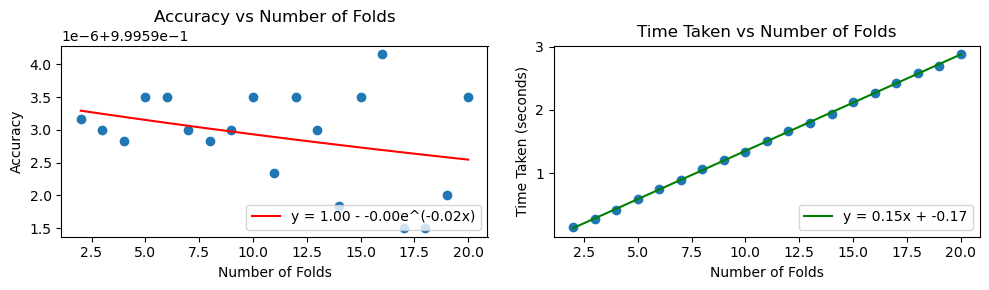

In [114]:
import time
from sklearn.model_selection import cross_val_score

folds = range(2, 21)  # K values from 2 to 20
accuracies = []
times = []

for k in folds:
    start_time = time.time()
    scores = cross_val_score(best_model_svm, X_train, y_train, cv=k)
    end_time = time.time()
    
    accuracies.append(np.mean(scores))
    times.append(end_time - start_time)
    
def plateau(x, a, b, c): #represents an exponential decay model that asymptotically approaches a plateau
    return a -(b)*np.e**(-c*x)

popt_plateau, pcov_plateau = curve_fit(plateau, folds, accuracies, p0=[0.9, 0.1, 0.1])
p2 = np.poly1d(np.polyfit(folds, times, 1))

# Plotting accuracy vs number of folds
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(folds, accuracies, marker='o', linestyle = "")
plt.plot(folds, plateau(folds, *popt_plateau), 'r-', label = f"y = {popt_plateau[0] :.2f} - {popt_plateau[1] :.2f}e^(-{popt_plateau[2] :.2f}x)")
plt.xlabel('Number of Folds')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title('Accuracy vs Number of Folds')

# Plotting time taken vs number of folds
plt.subplot(1, 2, 2)
plt.plot(folds, times, marker='o', linestyle = "")
plt.plot(folds, p2(folds), 'g-', label = f"y = {p2[1] :.2f}x + {p2[0] :.2f}")
plt.xlabel('Number of Folds')
plt.ylabel('Time Taken (seconds)')
plt.legend(loc = 'lower right')
plt.title('Time Taken vs Number of Folds')

plt.tight_layout()
plt.show()


ROC curve (Receiver Operating Characteristic)

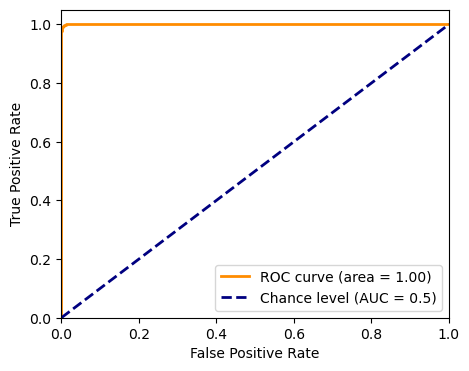

In [115]:
from sklearn.metrics import roc_curve, auc

# obtain probability scores instead of class labels using method='predict_proba'
y_scores_cv = cross_val_predict(clf_pipeline, X_svm, y_svm, cv=10, method='predict_proba')

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_svm, y_scores_cv[:, 1]) # FPR = false positive rate, TPR = true positive rate
roc_auc = auc(fpr, tpr) # AUC = area under the curve, useful metrric for evaluating binary classification

# Plotting ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance level (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


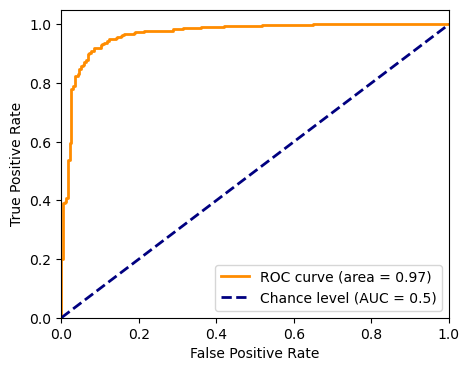

In [19]:
# Get probability scores for the positive class
y_scores = best_model_svm.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance level (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


- F1 score: a harmonic mean of the precision and recall, (best value = 1), $F1 = 2  \times \frac{precision \times recall} {precision + recall}$
    - balance between precision and recall
    - precision: TP / (TP + FP)
        - important in applications where false positives are more important than false negatives e.g. spam detection
    - recall (true positive rate): TP / (TP + FN)
        - critical in certian applications such as disease detection where a FN (missing a positive case) is much worse than a FP (false alarm
    - limitation: treats precision and recall equally, some situtations a weighted F1 score may be more appropriate


### Random Forest, Decision Tree Classifiers XGBoost

DT:
- good for interpretability

RF:
- a single decision tree can be highly sensitive to small changes in data
    - changing only a few data points can result in a different decision tree
- tree ensembles make the model more robust
    - less sensitive to noise and less overfitting than DTs due to averaging

XGBoost:
- XGBoost is an implementation of gradient boosted decision trees designed for speed and performance
- deliberate practice: focuses on the subset of examples we're not doing well on and make the next decision tree concentrate on it 
- Boosting transforms weak learners (decision trees) into strong learners, where each tree is build considering the errors of previous trees

Regularisation:
- hyperparameters to control model complexity (in function arguments)
- e.g. max_depth, min_child_weight, gamma, subsample, colsample_bytree, reg_alpha, reg_lambda

In [20]:
#feature_names = ["deltaI_c", "deltaI_r", "deltaI_c/deltaI_r", "dwell_time", "skew", "kurtosis", "area","entropy","n5", "n25", "n75", "n95", "median", "mean", "std", "var", "rms"]
#feature_names = ["deltaI_c", "deltaI_r", "deltaI_c/deltaI_r", "dwell_time", "skew", "kurtosis", "area","entropy", "mean", "std", "var", "rms"]
#feature_names = ["$\Delta I_c$", "$\Delta I_r$", "$\Delta I_c$ / $\Delta I_r$", "Dwell time", "Skew", "Kurtosis", "Total area", "Conductive area", "Resistive area","Entropy", "Mean", "STD", "Var", "RMS", "max deriv", "min deriv", "sum absolute deriv changes", "deriv sign changes sum", "decay_time_lhs", "decay_time_rhs"]
feature_names = ["$\Delta I_c$", "$\Delta I_r$", "$\Delta I_c$ / $\Delta I_r$", "Dwell time", "Skew", "Kurtosis", "Total area", "Conductive area", "Resistive area","Entropy", "Mean", "STD", "Var", "RMS", "max deriv", "min deriv", "sum absolute deriv changes", "deriv sign changes sum"]


Random Forest Cross-Validation Accuracy: 1.00 ± 0.00
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1124
         1.0       1.00      1.00      1.00      1949

    accuracy                           1.00      3073
   macro avg       1.00      1.00      1.00      3073
weighted avg       1.00      1.00      1.00      3073



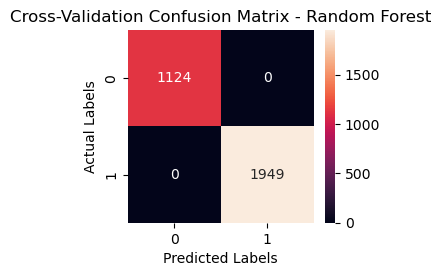

Decision Tree Cross-Validation Accuracy: 1.00 ± 0.00
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1124
         1.0       1.00      1.00      1.00      1949

    accuracy                           1.00      3073
   macro avg       1.00      1.00      1.00      3073
weighted avg       1.00      1.00      1.00      3073



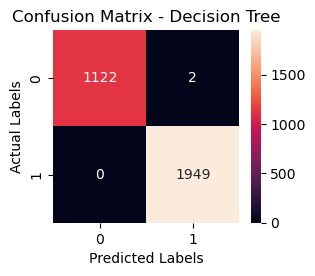

In [116]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_predict



# Create a pipeline that first applies SMOTE and then fits the model for Random Forest
pipeline_RF = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('random_forest', RandomForestClassifier(random_state=0))
])

# Perform 10-fold cross-validation for Random Forest
scores_RF = cross_val_score(pipeline_RF, X_scaled, y, cv=10)
scores_RF_avg = np.mean(scores_RF)
scores_RF_sd = np.std(scores_RF)
print(f"Random Forest Cross-Validation Accuracy: {scores_RF_avg:.2f} ± {scores_RF_sd:.2f}")

# Get cross-validated predictions for Random Forest
y_pred_RF_cv = cross_val_predict(pipeline_RF, X_scaled, y, cv=10)
print("Classification Report:")
print(classification_report(y_svm, y_pred_RF_cv))

# Confusion Matrix for Random Forest
cm_RF = confusion_matrix(y, y_pred_RF_cv)
plt.figure(figsize=(3, 2.5))
sns.heatmap(cm_RF, annot=True, fmt="d")
plt.title("Cross-Validation Confusion Matrix - Random Forest")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()



# Create a pipeline for Decision Tree
pipeline_DT = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('decision_tree', DecisionTreeClassifier(random_state=0))
])

# Perform 10-fold cross-validation for Decision Tree
scores_DT = cross_val_score(pipeline_DT, X_scaled, y, cv=10)
scores_DT_avg = np.mean(scores_DT)
scores_DT_sd = np.std(scores_DT)
print(f"Decision Tree Cross-Validation Accuracy: {scores_DT_avg:.2f} ± {scores_DT_sd:.2f}")

# Get cross-validated predictions for Decision Tree
y_pred_DT_cv = cross_val_predict(pipeline_DT, X_scaled, y, cv=10)
print("Classification Report:")
print(classification_report(y_svm, y_pred_DT_cv))

# Confusion Matrix for Decision Tree
cm_DT = confusion_matrix(y, y_pred_DT_cv)
plt.figure(figsize=(3, 2.5))
sns.heatmap(cm_DT, annot=True, fmt="d")
plt.title("Confusion Matrix - Decision Tree")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


- Do the features make sense
- what are the most important features
- interpretable model

randomised serach for RF and DT

In [120]:
from scipy.stats import randint

X_train, X_test, y_train, y_test = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42)


# Hyperparameter space for Random Forest
rf_params = {
    'bootstrap': [True, False],
    'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80],
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'max_features': ['sqrt', None]
}

# Randomized Search
rf_random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    n_iter=60,
    cv=10,
    scoring='accuracy',
    random_state=42
)
rf_random_search.fit(X_train, y_train)

print("Random Forest Best Parameters:", rf_random_search.best_params_)
print("Best Score:", rf_random_search.best_score_)

Random Forest Best Parameters: {'bootstrap': True, 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 56}
Best Score: 1.0


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       236
         1.0       1.00      1.00      1.00       379

    accuracy                           1.00       615
   macro avg       1.00      1.00      1.00       615
weighted avg       1.00      1.00      1.00       615

Accuracy: 1.0


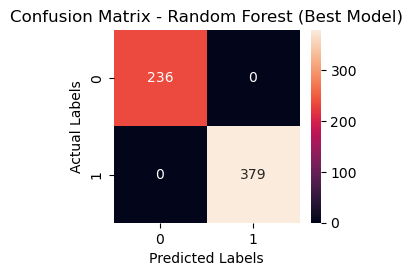

In [121]:
best_model_RF = rf_random_search.best_estimator_
predictions_best_model_RF = best_model_RF.predict(X_test)
print(classification_report(y_test, predictions_best_model_RF))
print("Accuracy:", accuracy_score(y_test, predictions_best_model_RF))

cm_best_model_RF = confusion_matrix(y_test, predictions_best_model_RF)
plt.figure(figsize=(3, 2.5))
sns.heatmap(cm_best_model_RF, annot=True, fmt="d")
plt.title("Confusion Matrix - Random Forest (Best Model)")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42)

# Hyperparameter space for Decision Trees
dt_params = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Randomized Search
dt_random_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    n_iter=60,
    cv=10,
    scoring='accuracy',
    random_state=42
)
dt_random_search.fit(X_train, y_train)

print("Decision Tree Best Parameters:", dt_random_search.best_params_)
print("Best Score:", dt_random_search.best_score_)

Decision Tree Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 7}
Best Score: 0.8750987224157954


              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82       236
         1.0       0.88      0.90      0.89       379

    accuracy                           0.87       615
   macro avg       0.86      0.85      0.86       615
weighted avg       0.86      0.87      0.86       615

Accuracy: 0.865040650406504


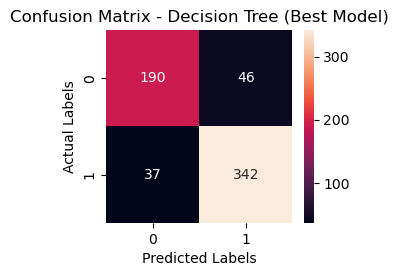

In [27]:
best_model_DT = dt_random_search.best_estimator_
predictions_best_model_DT = best_model_DT.predict(X_test)
print(classification_report(y_test, predictions_best_model_DT))
print("Accuracy:", accuracy_score(y_test, predictions_best_model_DT))

cm_best_model_DT = confusion_matrix(y_test, predictions_best_model_DT)
plt.figure(figsize=(3, 2.5))
sns.heatmap(cm_best_model_DT, annot=True, fmt="d")
plt.title("Confusion Matrix - Decision Tree (Best Model)")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

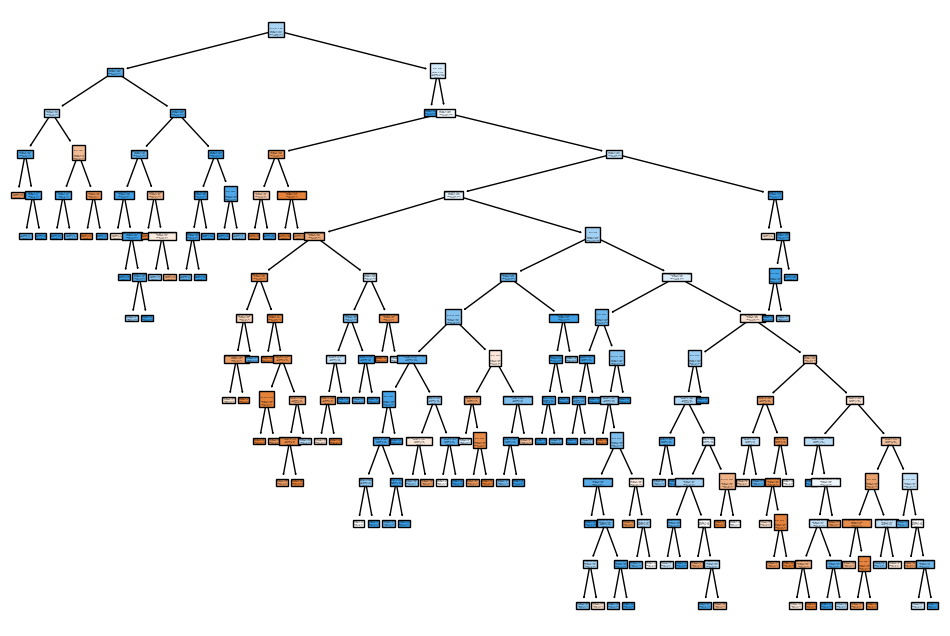

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_model_DT, filled=True, feature_names=feature_names, class_names=["0", "1"])
plt.show()


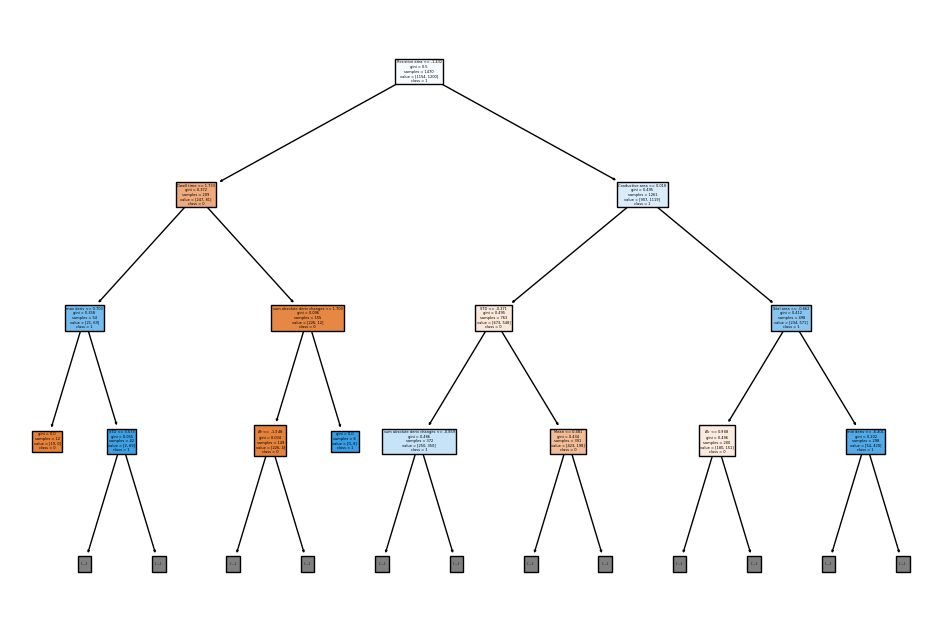

In [ ]:
from sklearn.tree import plot_tree

estimator = model_RF.estimators_[2]
plt.figure(figsize=(12, 8))
plot_tree(estimator, filled=True, feature_names=feature_names, class_names=["0", "1"], max_depth=3)  # Limiting depth for readability
plt.show()

# gini: Gini impurity, a measure used to quantify how often a  randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.
# often used as a criterion for making splits: a split that decreases the Gini impurity the most is chosen at each step

In [ ]:
%matplotlib inline

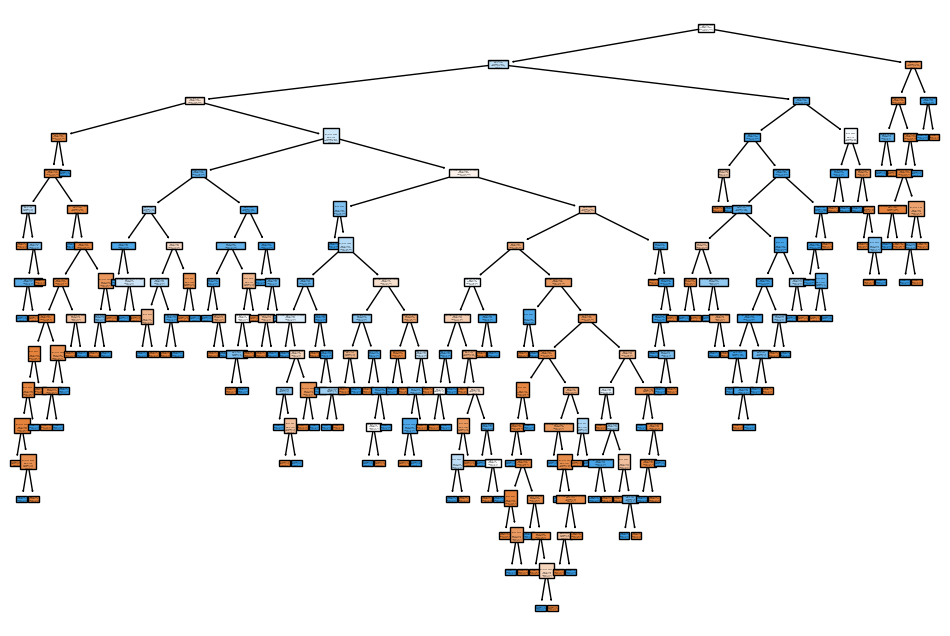

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8))
plot_tree(model_DT, filled=True, feature_names=feature_names, class_names=["0", "1"])
#plt.savefig("MSci_python_images/DT_tree.png", dpi=1000)
plt.show()

#### XGBoost

scale_pos_weight

XGBoost Cross-Validation Accuracy: 0.90 ± 0.03
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87      1124
         1.0       0.93      0.91      0.92      1949

    accuracy                           0.90      3073
   macro avg       0.89      0.90      0.89      3073
weighted avg       0.90      0.90      0.90      3073



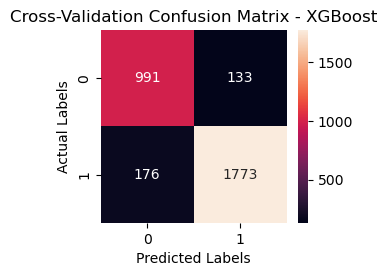

In [28]:
import xgboost as xgb
from xgboost import XGBClassifier


pipeline_XG = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('random_forest', XGBClassifier(random_state=0))
])

scores_XG = cross_val_score(pipeline_XG, X_scaled, y, cv=10)
scores_XG_avg = np.mean(scores_XG)
scores_XG_sd = np.std(scores_XG)
print(f"XGBoost Cross-Validation Accuracy: {scores_XG_avg:.2f} ± {scores_XG_sd:.2f}")

y_pred_XG_cv = cross_val_predict(pipeline_XG, X_scaled, y, cv=10)
print("Classification Report:")
print(classification_report(y_svm, y_pred_XG_cv))

# Confusion Matrix for Random Forest
cm_XG = confusion_matrix(y_svm, y_pred_XG_cv)
plt.figure(figsize=(3, 2.5))
sns.heatmap(cm_XG, annot=True, fmt="d")
plt.title("Cross-Validation Confusion Matrix - XGBoost")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

Randomised search for XGBoost

In [ ]:
print(expon(scale=0.1))

In [29]:
from scipy import stats

In [30]:
# Hyperparameter space for XGBoost
xgb_params = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 20),
    'learning_rate': expon(scale=0.1),
    'subsample': [0.5, 0.75, 1.0],
    'min_child_weight' : [ 1, 3, 5, 7 ],
    'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    'colsample_bytree': [ 0.3, 0.4, 0.5 , 0.7 ]
}

# Randomized Search
xgb_random_search = RandomizedSearchCV(
    XGBClassifier(random_state=42),
    xgb_params,
    n_iter=60,
    cv=10,
    scoring='accuracy',
    random_state=42
)
xgb_random_search.fit(X_train, y_train)

print("XGBoost Best Parameters:", xgb_random_search.best_params_)
print("Best Score:", xgb_random_search.best_score_)

XGBoost Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.10273106935677051, 'max_depth': 13, 'min_child_weight': 1, 'n_estimators': 519, 'subsample': 0.75}
Best Score: 0.9328704164592667


              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89       236
         1.0       0.93      0.94      0.94       379

    accuracy                           0.92       615
   macro avg       0.92      0.91      0.92       615
weighted avg       0.92      0.92      0.92       615

Accuracy: 0.9203252032520325


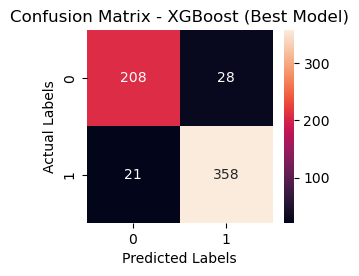

In [31]:
best_model_XG = xgb_random_search.best_estimator_
predictions_best_model_XG = best_model_XG.predict(X_test)
print(classification_report(y_test, predictions_best_model_XG))
print("Accuracy:", accuracy_score(y_test, predictions_best_model_XG))

cm_best_model_XG = confusion_matrix(y_test, predictions_best_model_XG)
plt.figure(figsize=(3, 2.5))
sns.heatmap(cm_best_model_XG, annot=True, fmt="d")
plt.title("Confusion Matrix - XGBoost (Best Model)")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

Feature importances
- find out how they're calculated

In [119]:
len(best_model_RF.feature_importances_)

18

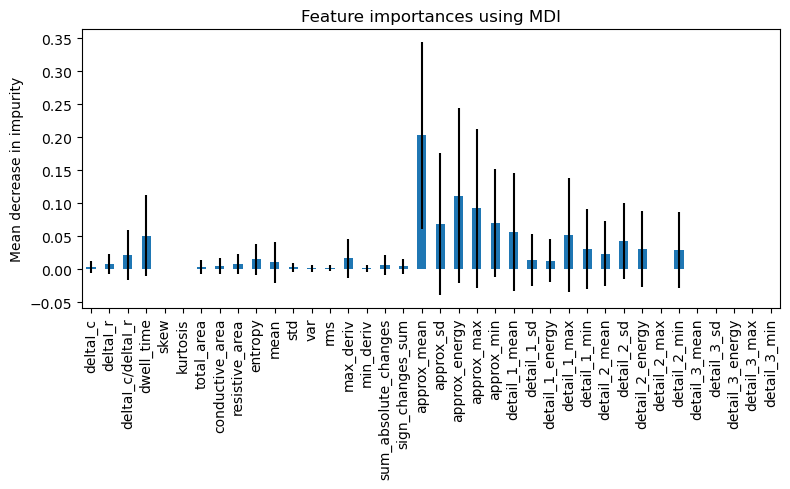

In [122]:
# Feature importances based on mean decrease in impurity (MDI)
importances_MDI = best_model_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model_RF.estimators_], axis=0)

forest_importances = pd.Series(importances_MDI, index=feature_names)

fig, ax = plt.subplots(figsize=(8, 5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

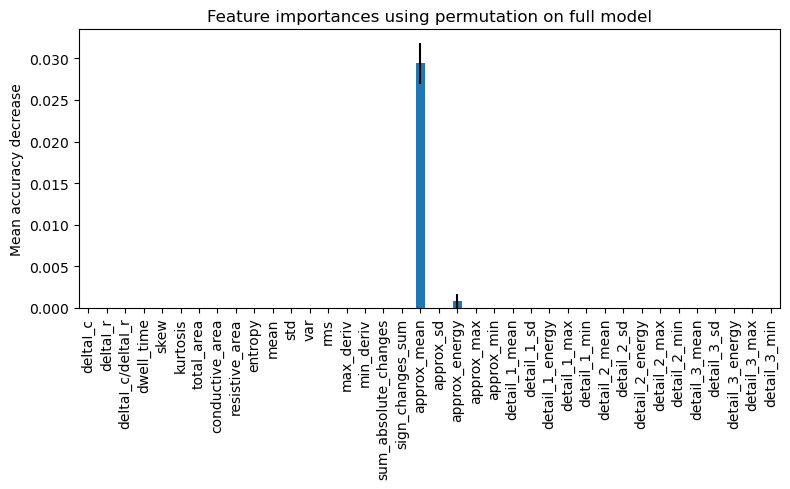

In [123]:
# Feature importances based on mean feature permutation
# mean decrease in accuracy (MDA): the decrease in a model score when a feature value is randomly shuffled/ disrupted

from sklearn.inspection import permutation_importance

result = permutation_importance(best_model_RF, X_test, y_test, n_repeats=10, random_state=0, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots(figsize=(8, 5))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
importances_MDI_XG = best_model_XG.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model_XG.estimators_], axis=0)

forest_importances = pd.Series(importances_MDI, index=feature_names)

fig, ax = plt.subplots(figsize=(8, 5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

AttributeError: 'XGBClassifier' object has no attribute 'estimators_'

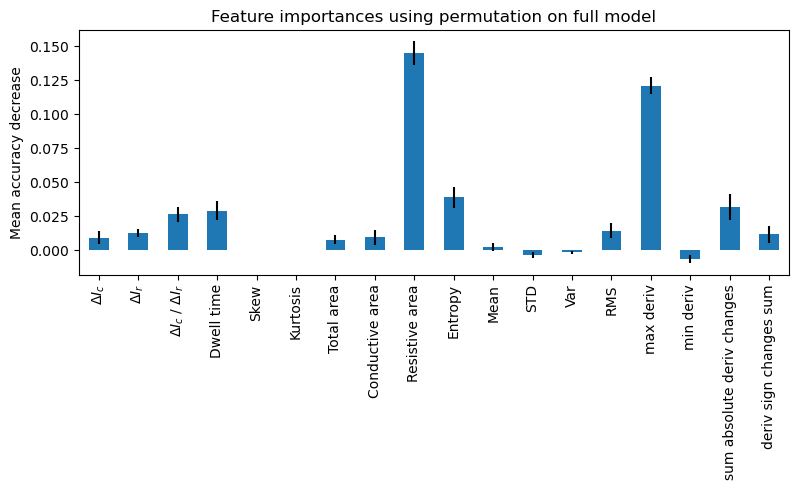

In [ ]:
result = permutation_importance(best_model_XG, X_test, y_test, n_repeats=10, random_state=0, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots(figsize=(8, 5))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Reviewing misclassified events

In [34]:
predictions_best_model_RF

array([1., 1., 1., ..., 1., 1., 0.])

In [35]:
len(y_test[y_test != predictions_best_model_RF])

56

In [62]:
misclassified = y_test[y_test != predictions_best_model_RF]
misclasssified_TF = y_test != predictions_best_model_RF
print(f"Number of misclassified instances: {len(misclassified)} out of {len(predictions_best_model_RF)}")

df_X_test = pd.DataFrame(X_test, columns=feature_names)
df_X_test['composite_key'] = df_X_test.apply(lambda row: '-'.join(row.values.astype(str)), axis=1)

df_X_test['actual'] = y_test
df_X_test['predicted'] = predictions_best_model_RF
df_X_test['misclassified'] = misclasssified_TF

# Filter to only include misclassified instances
df_X_test_misclassified = df_X_test[df_X_test['misclassified']]

# Now you can review df_misclassified to analyze the misclassified cases
df_X_test_misclassified.head()

Number of misclassified instances: 56 out of 615


,$\Delta I_c$,$\Delta I_r$,$\Delta I_c$ / $\Delta I_r$,Dwell time,Skew,Kurtosis,Total area,Conductive area,Resistive area,Entropy,...,Var,RMS,max deriv,min deriv,sum absolute deriv changes,deriv sign changes sum,composite_key,actual,predicted,misclassified
5,-0.327950,0.596741,1.629984,-0.123288,0.0,0.0,0.854854,-0.127381,0.464771,-0.069284,...,-0.253696,-0.197640,-0.477609,0.256843,-0.431128,0.857143,-0.32795037373200125-0.5967409888243923-1.6299...,1.0,0.0,True
15,-0.557200,0.478743,0.452423,-0.109589,0.0,0.0,0.281444,-0.348604,0.409380,-0.815561,...,-0.403474,-0.534929,-0.635266,0.649190,-0.840989,1.428571,-0.5572004998523422-0.478743056909922-0.452422...,0.0,1.0,True
17,-0.634515,1.216803,57.412249,1.315068,0.0,0.0,5.595803,1.701692,0.868479,-0.031089,...,-0.172404,0.407831,-2.058922,-2.018106,-1.112242,0.285714,-0.6345151188658096-1.2168027491430182-57.4122...,0.0,1.0,True
24,-0.524765,-0.005744,-0.730593,-0.041096,0.0,0.0,0.063787,-0.432577,0.001559,0.014209,...,-0.211634,-0.123226,-0.440037,0.959680,-0.391629,0.142857,-0.5247650741442615--0.005744353149583848--0.7...,0.0,1.0,True
28,-0.021390,0.360715,1.072432,-0.095890,0.0,0.0,1.273834,0.034263,0.474150,-0.793429,...,-0.268796,-0.419171,-0.356567,-0.370222,0.103208,0.000000,-0.021390390322978656-0.3607145746391556-1.072...,0.0,1.0,True


In [93]:
original_misclassified_events = features_and_labels_scaled_df[features_and_labels_scaled_df['composite_key'].isin(df_X_test_misclassified['composite_key'])]
original_misclassified_events.head()


,$\Delta I_c$,$\Delta I_r$,$\Delta I_c$ / $\Delta I_r$,Dwell time,Skew,Kurtosis,Total area,Conductive area,Resistive area,Entropy,Mean,STD,Var,RMS,max deriv,min deriv,sum absolute deriv changes,deriv sign changes sum,composite_key,Labels
14,-0.219020,0.341079,0.614576,-0.123288,0.0,0.0,0.217095,-0.373430,0.142410,-0.226848,0.222187,-0.210765,-0.181068,-0.144403,-0.105249,0.111838,-0.260655,0.571429,-0.21901998295471092-0.3410789558896412-0.6145...,0.0
32,-0.778004,0.878426,2.819960,-0.136986,0.0,0.0,1.067056,-0.045512,0.730321,-0.758030,1.084334,-0.694240,-0.481437,-0.606178,-1.298670,0.269235,-0.856851,0.428571,-0.7780037448471193-0.8784262077882538-2.81996...,0.0
44,-0.751549,0.555813,0.321319,-0.150685,0.0,0.0,0.294244,-0.343666,0.409151,-0.479509,0.299607,-0.567415,-0.418140,-0.449382,-0.730646,0.472598,-0.482351,0.714286,-0.7515486074178137-0.5558134368745176-0.32131...,0.0
52,-0.790107,0.611287,0.481093,-0.095890,0.0,0.0,0.539819,-0.248922,0.514565,-0.596511,0.548268,-0.636455,-0.453964,-0.537659,-1.175711,0.795673,-0.823913,0.428571,-0.790107080703719-0.6112872987246198-0.481092...,0.0
93,-0.722292,0.467466,0.042320,-0.068493,0.0,0.0,-0.341345,-0.588878,0.212067,-0.454005,-0.345705,-0.458149,-0.354769,-0.366041,-0.668210,1.073322,-0.367046,0.714286,-0.722292298465255-0.4674661166681914-0.042320...,0.0


In [66]:
misclassified_indices = original_misclassified_events.index.values.tolist()

In [96]:
unscaled_misclassified_events = features_and_labels_df.iloc[misclassified_indices]
unscaled_misclassified_events.head()

,$\Delta I_c$,$\Delta I_r$,$\Delta I_c$ / $\Delta I_r$,Dwell time,Skew,Kurtosis,Total area,Conductive area,Resistive area,Entropy,Mean,STD,Var,RMS,max deriv,min deriv,sum absolute deriv changes,deriv sign changes sum,composite_key,Labels
14,63.767677,-28.922598,2.204770,0.000046,0.0,0.0,0.000365,0.000365,-0.005137,3.181865,0.281705,14.109114,199.067112,8.347848,7.124284,-2.890987,286.660935,32.0,63.7676768375745--28.922598337428372-2.2047699...,0.0
32,43.583701,-11.933444,3.652232,0.000044,0.0,0.0,0.002980,0.002980,-0.000977,2.724791,2.298929,8.169788,66.745439,4.387465,3.296655,-2.705960,224.892583,31.0,43.583701452829445--11.933443920025123-3.65223...,0.0
44,44.538953,-22.133400,2.012296,0.000042,0.0,0.0,0.000602,0.000602,-0.003250,2.964454,0.462851,9.727787,94.629846,5.732215,5.118462,-2.466897,263.692322,33.0,44.53895253358611--22.133399652029038-2.012296...,0.0
52,43.146670,-20.379498,2.117161,0.000050,0.0,0.0,0.001358,0.001358,-0.002504,2.863776,1.044660,8.879658,78.848330,4.975110,3.691017,-2.087109,228.305103,31.0,43.146670094036715--20.379498423780255-2.11716...,0.0
93,45.595349,-24.926652,1.829181,0.000054,0.0,0.0,-0.001354,-0.001354,-0.004644,2.986400,-1.047029,11.070081,122.546704,6.446978,5.318714,-1.760720,275.638351,33.0,45.59534926637815--24.92665161348551-1.8291806...,0.0


In [103]:
np.average(unscaled_misclassified_events['$\Delta I_c$'])

58.11020150290194

In [98]:
unscaled_misclassified_events[unscaled_misclassified_events['$\Delta I_c$']>100]

,$\Delta I_c$,$\Delta I_r$,$\Delta I_c$ / $\Delta I_r$,Dwell time,Skew,Kurtosis,Total area,Conductive area,Resistive area,Entropy,Mean,STD,Var,RMS,max deriv,min deriv,sum absolute deriv changes,deriv sign changes sum,composite_key,Labels
1055,129.768922,-45.258326,2.867294,0.000838,0.0,0.0,0.013830,0.013830,-0.009569,4.654003,12.196596,45.787766,2096.519538,39.863467,10.051237,-22.234024,843.668814,28.0,129.76892232359293--45.25832614413978-2.867293...,0.0
1714,103.126992,-88.191856,1.169348,0.000322,0.0,0.0,-0.012314,0.011862,-0.024158,4.510473,-9.839014,38.800690,1505.493536,28.840771,9.823978,-2.856932,427.267575,19.0,103.12699188292135--88.19185586700497-1.169348...,1.0


In [104]:
len(all_event_data[1055])

558

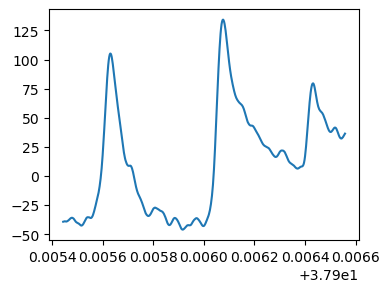

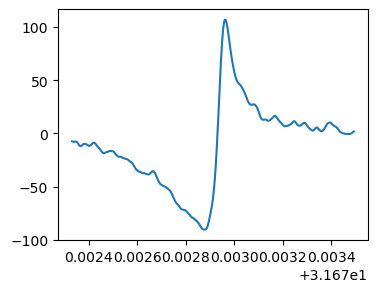

In [102]:
plt.figure(figsize=(4, 3))
plt.plot(all_event_time[1055], all_event_data[1055])
plt.show()
plt.figure(figsize=(4, 3))

plt.plot(all_event_time[1714], all_event_data[1714])

In [97]:
np.max(unscaled_misclassified_events['$\Delta I_c$'])

129.76892232359293

In [82]:
np.max(features_and_labels_df['$\Delta I_c$'])

7.4610585391201605

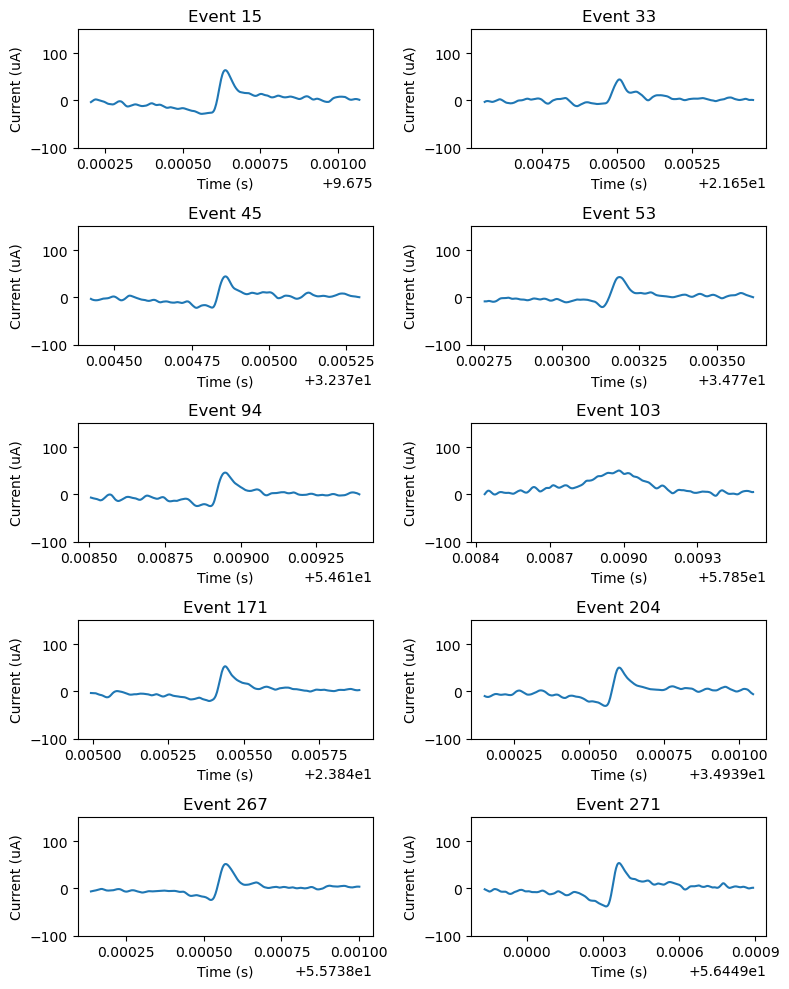

In [80]:
num_rows = 5  # Adjust as needed
num_cols = 2  # Adjust as needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 2 * num_rows))

for i in range(10):
    row = (i) // num_cols  # Determine the row of the subplot
    col = (i) % num_cols   # Determine the column of the subplot

    ax = axes[row, col]  # Get the subplot axis
    ax.plot(all_event_time[misclassified_indices[i]], all_event_data[misclassified_indices[i]])

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Current (uA)')
    ax.set_ylim(-100, 150)
    ax.set_title(f'Event {misclassified_indices[i]+1}')
    #ax.legend(loc = 'upper right', fontsize = 'x-small')
    # Set the x-axis to have a maximum of 4 ticks
    ax.xaxis.set_major_locator(MaxNLocator(4))

plt.tight_layout()
#plt.savefig('MSci_python_images/event_isolation_5nm_0002.png', dpi=300)
plt.show()


### All wavelet comparison

### Feedback

- compare 5nm and 10nm dwell times and amplitudes etc in nanopore app

- clustering with features for 5vs10

- Can use derivative as a feature to detect 2 peaks
- Savinski-golay derivative

- grid search with cross validaiton to find number of clusters

- for dimer events, not much data of actual dimer peaks -> unsupervised leanring more sensible
    - dimer events likely 5% of peaks (also are slower than monomer)
- could use KDE for 5nm vs 10, get probability


5v10:
- fully connected neural net
- input whole current trace
- output is classificaiton layer which performs multiclass classificaton
- use softmax activation function for output layer to get a probability (negative log liklihood loss, negative as its turns a maximisation problem into a minimisation problem (minimisation problems are easier))
- for neural networks: " a combination of L2 regularization, dropout, and early stopping might be effective"
- dropout layers to regularise the model: "DeepSelectNet: deep neural network based selective sequencing for oxford nanopore sequencing"

noise:
- play with low pass cutoff to maximise SNR
- try to correct each freq of spectrum

- compare accuracy of model with every type of wavelet and also no DWT applied

- Graph Neural Networks (GNNs)
    - self-organsing maps
    - to see trends in data
    

Evaulating model performance:
- Common metrics include accuracy, precision, recall, F1 score, ROC-AUC for classification tasks

- for combined data javier and oliver couldnt find a difference

advanatges of nanopore sensing over e.g. mass spec?

- decay and coefficents as features

- anomalie classificaiton (can be useful for dimers, and colliodal systems in general as they can contain monomers, dimers, trimers etc)
    - can identify before training the models and assigning labels

- do the plots in the nanopore app (e.g. peak amplitude vs dwell time) of 5 and 10 nm to see if easily seperable
- do PCA using the 20 features
- plot pc1 and pc2 for 5nm, 10nm and the mixture
- if pc1 can separate them, can look at most important features in pc1
- if the mixture doesnt overlap, the system changes when you add the other nanoparticle

- review misclassified events

- ROC

Combined 5 and 10 nm run: (how to guage accuracy)
- p-value for 5nm vs 10nm likelihood
- null hypothesis and alternative hypothesis
    - e.g. null hypothesis: it is a 5 nm NP
    - assign probabiliteis of the similiarity the signal is compared to your training data